https://colab.research.google.com/drive/1hNXzjwgmW1pAUgBX-ofM6Z_q10hUg0Kr?usp=sharing


## Content

- Regressor
- Matrix Factorization from Scatch
- Matrix Factorization using Library
- Measurement

### Is it possible to frame the Recommendation problem as a Regression?
Yes,
- In a regression-based approach, you treat the recommendation problem as a regression task where the goal is to predict user ratings directly using user and item features as input.
- You might use regression models like linear regression, decision trees, or neural networks to model the relationship between user and item features and user ratings.

<center><img src="https://drive.google.com/uc?id=1BqICxqGDppxnZbeEf2VwxMKLdNp5kQ6P"></center>

---

##Recommender Systems

- Recommender systems play a pivotal role in many online platforms, enabling users to discover new content or products tailored to their preferences.
- Among the various techniques for building recommendation systems, collaborative filtering stands out as a widely adopted approach.
- In this notebook, we will delve into the world of collaborative filtering, matrix factorization, and the assessment of recommendation systems.

Let's begin by loading and preprocessing the data:

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
!gdown 1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1
!gdown 1HOFWUAMFlYbd-gk1B2IyV2-hXDZI7gKR
!gdown 1b7_yRRBs3s3atp1WQHN2GU577vxY8u_h

Downloading...
From: https://drive.google.com/uc?id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1
To: /content/movies.csv
100% 516k/516k [00:00<00:00, 20.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HOFWUAMFlYbd-gk1B2IyV2-hXDZI7gKR
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 56.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b7_yRRBs3s3atp1WQHN2GU577vxY8u_h
To: /content/users.csv
100% 16.8k/16.8k [00:00<00:00, 42.8MB/s]


In [3]:
# Loading Data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

Selecting the data with most frequently rated movies by counting the number of ratings for each movie and selecting the top 1000 movies with the highest rating counts.



In [4]:
select_movies = ratings.movieId.value_counts().head(1000).index.to_list()
movies = movies.loc[movies.movieId.isin(select_movies)]
ratings = ratings.loc[ratings.movieId.isin(select_movies)]

**Movies data**

In [5]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


**Ratings data**

In [6]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807


### Transforming Movie Genres into Binary Features
- We are transforming the data in this manner to prepare it for use in recommendation system.
- By representing genres as binary features (1 for belonging to a genre and 0 for not), we create a structured dataset that is more suitable for training recommendation models.
- This transformation simplifies the data and allows us to quantify the presence or absence of specific genres for each movie, making it easier to identify genre preferences and similarities among users and movies.

In [7]:
m = movies.copy()
m['genres'] = m['genres'].str.split('|')
m = m.explode('genres')
m = m.pivot(index='movieId', columns='genres', values='title')
m = ~m.isna()
m = m.astype(int)
m.head(2)

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Extracting Hour from Timestamp

 - Extracting the hour from the timestamp can indeed serve as a valuable user feature.
 - By incorporating the hour of the day when users provide ratings, it provides a means to capture time-based patterns and behaviors of users.

In [ ]:
r = ratings.copy()

In [ ]:
r['hour'] = r['timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
r.head()

,userId,movieId,rating,timestamp,hour
0,1,16,4.0,1217897793,0
1,1,24,1.5,1217895807,0
2,1,32,4.0,1217896246,0
3,1,47,4.0,1217896556,0
4,1,50,4.0,1217896523,0


- Merging user data with aggregated statistics from ratings.
- It adds features for each user's average rating and the average hour of rating submission, enhancing user profiles for recommendation systems.

In [ ]:
users = pd.read_csv('users.csv')
users = users.merge(r.groupby('userId').rating.mean().reset_index(), on='userId')
users = users.merge(r.groupby('userId').hour.mean().reset_index(), on='userId')
users.head(2)

,userId,age,time_spent_per_day,rating,hour
0,1,16,3.976315,3.691589,0.0
1,2,24,1.891303,3.923077,16.0


Now we have created the user-user similarity matrix and item-item similarity matrix, which is movie genre data.

## How can we use this information to build the regressor?

> We know that **rating** is our target variable.

### What should be our features?

**users:** userId, age, time_spent_per_day, avg_hour, avg_rating

**ratings:** movie_id

**movies:** Action, Adventure, Animation, Children, Comedy, Crime, Documentary,	Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi,	Thriller,	War	Western

We'll use the above features from the respective data to build the regressor model.

Before that Let's Rescale the data

In [ ]:
u = users.copy()
u = u.set_index('userId')
u.columns = ['age', 'time_spent_per_day', 'u_avg_rating', 'hour']

scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)
u.head(2)

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-1.900624
2,-0.135616,-1.079947,0.426461,0.610601


## Regression Based

In [ ]:
m.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
u.head()

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-1.900624
2,-0.135616,-1.079947,0.426461,0.610601
3,-0.802954,0.712624,0.174541,-0.488060
4,-0.302450,-0.940926,0.936982,-1.577622
5,1.699565,-1.169532,-1.859363,1.081456


 ### Creating Final Feature Matrix

 - Creating a merged DataFrame **X** by combining user and movie data with their respective ratings.
 - Selecting columns **movieId**, **userId**and **rating** from the ratings dataset, then merges this data with user information and movie information based on **userId** and **movieId** respectively.
 - The result is a combined dataset that includes user and movie attributes along with their ratings, providing a comprehensive basis for building recommendation models.

In [ ]:
X = ratings[['movieId', 'userId', 'rating']].copy()
X = X.merge(u.reset_index(), on='userId', how='right')
X = X.merge(m.reset_index(), on='movieId', how='right')
X.head()

,movieId,userId,rating,age,time_spent_per_day,u_avg_rating,hour,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,5.0,-0.135616,-1.079947,0.426461,0.610601,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,5,4.0,1.699565,-1.169532,-1.859363,1.081456,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,8,5.0,0.364888,0.298545,0.160605,0.453650,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,11,4.0,-1.303458,0.513712,-0.380602,-0.424244,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,14,4.0,-0.302450,1.251552,-0.379415,-0.488060,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = X.drop(columns = ['movieId', 'userId'])
y = X.pop('rating')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Building Regression Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE is a better choice for recommendation systems with discrete and bounded ratings

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, y_pred)**0.5

0.8868226507109813

- On avg my rating is off by 0.88 units. Maybe this can be better.

## Does Cold start problem occur with this model?

Can we still predict the ratings even if new user and movie is added?

Yes, Because some user based information is required like **u_avg_rating** and **hour**

Ratings for User 1

In [ ]:
ratings.loc[ratings.userId==1].head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


Predicting rating for User 1 and movie 1

In [ ]:
model.predict(u.loc[1].append(m.loc[1]).values.reshape(1,-1))

array([3.70223883])

- Not that ideally scaler should also be learnt and be done before splitting. [Making exception here]
- If there is a new movie or a new user, based on thier features, we can predict the rating

We have built a regression model to predict the rating based on user and movie features. But it is not the efficient method for recommendation system due to:

- **Data Sparsity:**
 - Recommender systems often deal with sparse user-item interaction data.
 - Regression models require data for each user-item pair to make predictions
 - However, most users have not interacted with most items, leading to a lack of data for training the model for many user-item pairs.
 - This can result in a high number of missing values in the dataset, making it challenging for regression models to generalize effectively.

- **Cold Start Problem:** Regression models struggle with the "cold start problem," where new users or items with limited interaction history are introduced to the system.

- **Limited Latent Factor Capture:**
 - Regression models rely solely on explicit user and item features to make predictions.
 - They may not effectively capture latent factors or hidden patterns that significantly influence user-item interactions.
 - This can result in less accurate recommendations compared to matrix factorization, which inherently captures latent factors.

## How can we solve this problem?

## Collaborative Filtering

- **Collaborative filtering** is a recommendation methodology designed to automatically make predictions (filtering) about a user's interests by aggregating and analyzing preferences from a collective of users (collaborating).
- The core idea behind this approach is that users who have shared preferences in the past are likely to have shared preferences in the future.

- If 2 users like the same movies, they are similar.
- If 2 ovies are liked by the same users, they are similar.

Note, that instead of "2", similarity is approximated by as many data points as possbible.
popular movies maybe liked by everyone, does not mean that they are similar.

> this is hard to achieve because there are simultaneous interactions

One techinque to achive this, while dealing with sparsity is called **Matrix Factorisation**

## What is Matrix Factorization?

- **Matrix factorization** is a mathematical technique commonly used in recommendation systems to factorize a user-item interaction matrix into lower-dimensional matrices representing users and items.
- The core concept behind matrix factorization is to approximate the original matrix by decomposing it into two or more matrices.
- This process helps uncover latent factors that influence user-item interactions.


### Let's Breakdown the process of Matrix Factorization in Simple Steps

- User-Item Interaction Matrix:

 - In recommendation systems, you start with a user-item interaction matrix, often denoted as R.
 - Rows correspond to users, columns correspond to items, and the entries $R_{i,j}$ represent user ratings, interactions, or preferences for items.

 <center><img src="https://drive.google.com/uc?id=1gGxM-opp1666trtmfMlc6JY4Ue46imbn"></center>

- Decomposition:

 - Matrix factorization decomposes this user-item interaction matrix R into two lower-dimensional matrices, typically denoted as U (user matrix) and I (item matrix).

 <center><img src="https://drive.google.com/uc?id=1t3poDcWoe-ewAi_QCgEXe1SBoSgqZGOB"></center>

- Dimensions:

 - The dimensions of the user matrix U are M x K, where M is the number of users, and K is the number of latent factors. The item matrix I has dimensions of K x N, where N is the number of items.

- Objective Function:

 - The goal of matrix factorization is to find the matrices U and V such that the product U * V approximates the original matrix R.
 - To achieve this, an objective function is defined, often using a loss function like Mean Squared Error (MSE) or a variant of it.

 > $Loss = 𝚺 (R_{ij}-(U_{i}*I_{j}))^{2}$

 - Here, U_i and V_j are the latent factor vectors for the i-th user and j-th item, respectively.

- Optimization:

 - The matrices U and I are optimized to minimize the loss function. This is typically done using optimization techniques like Gradient Descent or Alternating Least Squares (ALS).

 - We'll use Gradient descent to optimize the loss function.

 <center><img src="https://drive.google.com/uc?id=1fgyQ-KUppMDSxL1zs78mJSu06FyDaG-2"></center>

 - The optimization process updates the latent factor vectors in U and V iteratively to improve the approximation of the original matrix R.
 - The objective is to find U and V that provide the best fit to the observed user-item interactions.

- Prediction:

 - Once the optimization is complete, the factorized matrices U and V can be used to predict missing values in the original matrix R.
 - These predictions are used to generate recommendations for users.





Ratings data

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


- Converting the original user-item interaction data into a user-item matrix where rows represent users, columns represent movies, and the entries contain user ratings.
- Any missing values (unrated movies) are filled with 0, creating a matrix suitable for collaborative filtering in recommendation systems.

In [ ]:
rm = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
rm.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,88125,89745,91529,96610,99114,109374,109487,111759,112852,116797
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Question:
- Should I convert to boolean like we did for apriori?
- Can you calculate the spasity of the matrix?

In [ ]:
(rm > 0).sum().sum() / (rm.shape[0] * rm.shape[1])

0.09468562874251497

- Only 9.5% of the values are filled
- Note that we only have 668 users and only took most popular 1000 movies !

### Matrix Factorisation from scratch

In [ ]:
rm_small = rm.copy()
rm_small = rm_small[rm_small.columns[:100]]
rm_small = rm_small.head(100)

- Matrix factorization using stochastic gradient descent to minimize the cost function.
- It iteratively optimizes latent factor matrices P and Q to approximate the user-item interaction matrix R. After optimization, it can predict user-item interactions and compares them with actual ratings.

In [ ]:
K = 2
P = np.random.normal(size=(rm_small.shape[0], K))
Q = np.random.normal(size=(rm_small.shape[1], K))

def matrix_factorization(R, P, Q, K, steps=10000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] == 0:
                    continue
                eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                for k in range(K):
                    x = P[i][k]
                    P[i][k] += alpha * (2 * eij * Q[k][j]) # - beta * P[i][k])
                    Q[k][j] += alpha * (2 * eij * x) # - beta * Q[k][j])
    return P, Q.T


P_, Q_ =  matrix_factorization(rm_small.values.copy(), P.copy(), Q.copy(), 2)


# Predicted Values vs Actual Ratings
print(np.dot(P_[4], Q_[36]), rm_small.values[4, 36])
print(np.dot(P_[1], Q_[0]), rm_small.values[1, 0])
print(np.dot(P_[1], Q_[2]), rm_small.values[1, 2])
print(np.dot(P_[3], Q_[17]), rm_small.values[3, 17])

0.5932895438440335 0.5
4.526008919449876 5.0
3.077520448859094 2.0
4.47810539508744 5.0


In [ ]:
from sklearn.metrics import mean_squared_error as mse
rm_ = np.dot(P_, Q_.T)
mse(rm_small.values[rm_small > 0], rm_[rm_small > 0])**0.5

0.6578132820062648

Now lets Implement collaborative filtering using Inbuilt library **cmfrec**

### Using cmfrec library

### Collective matrix factorisation for recommender systems
**Documentation:** https://cmfrec.readthedocs.io/en/latest/



- **cmfrec** library requires input in the form of dataframe not as sparse matrix.

- It required 3 columns UserId, ItemId, Rating.

In [ ]:
rm_raw = ratings[['userId', 'movieId', 'rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,16,4.0
1,1,24,1.5


- An instance of the CMF model is created with various hyperparameters:

 - **method="als":** Specifies the alternating least squares (ALS) optimization method, commonly used for matrix factorization in recommendation systems.

 - **k=2:** Sets the number of latent factors to 2, determining the dimensionality of the latent factor space.

 - **lambda_=0.1:** Sets the regularization strength to 0.1. Regularization is used to prevent overfitting in the model.

 - **user_bias=False:** Indicates that user bias terms are not included in the model. User bias represents a user's overall rating tendency.

 - **item_bias=False:** Excludes item bias terms in the model. Item bias represents an item's overall rating tendency.

 - **verbose=False:** Suppresses verbose output, controlling whether the model's training progress is displayed.

In [8]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.21-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post7-cp310-cp310-linux_x86_64.whl size=5830911 sha256=89e098a4798dc254176b24120198daeb77fded05a0e4eccd034a38edc69e3ed2
  Stored in directory: /root/.cache/pip/wheels/10/cf/c1/3b05df5e49ce0c5ed2e8fe63f377c6c2c23a63c8b327d8f734
Successfully built cmfrec


In [ ]:

from cmfrec import CMF

model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


Shape of User Matrix and Item matrix generated by **CMF**

In [ ]:
model.A_.shape, model.B_.shape

((668, 2), (1000, 2))

In [ ]:
rm_raw.Rating.mean(), model.glob_mean_

(3.6659130434782607, 3.6659131050109863)

In [ ]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.0629517113958387

- **MSE** obtained by CMF() is higher than the matrix factorization from scratch.

- But CMF() is much faster than the Matrix Factorization from scratch because it is optimized.

further read: https://nbviewer.org/github/david-cortes/cmfrec/blob/master/example/cmfrec_movielens_sideinfo.ipynb

## How to Measure performance of the Recommendation system?

- **MSE** can be used when you have to compare between the actual and predicted ratings.

- But in case of recommendation system, where we find the similarity between the embeddings, it is not possible to measure **MSE**.

- In this case, we can use a metric called **Overlap**


### What is Overlap?

- Overlap is a metric that quantifies the commonality between the set of items recommended to a user and the set of items the user has interacted with or rated positively.
- A higher overlap indicates that the recommendations align more closely with the user's interests, suggesting a more effective recommendation system.

<center><img src = "https://drive.google.com/uc?id=1V8CVGX2RfZHTux67c1G5F_yHPqhEs3Hk"></center>

**Example:**
Let's consider a scenario where a user, Sarah, is using a movie recommendation system. Sarah has rated and interacted with several movies, and the system aims to recommend new movies based on her preferences.

- Sarah has interacted with five movies: A, B, C, D, and E. These are the movies she has watched, rated, or liked.

- The recommendation system generates a list of ten movie recommendations for Sarah. These recommendations are labeled as 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10.

- To calculate the overlap, we compare the recommended movies (1 to 10) with the movies Sarah has interacted with (A to E).

Let's see which recommended movies overlap with Sarah's interactions:

- **Overlap:** Movies A, B, and D are part of Sarah's interactions and are also recommended (3 out of 10).

- **Non-Overlap:** Movies C and E are not part of the recommendations.

The overlap metric is calculated as the number of overlapping items divided by the total number of recommended items.

> In this case, the overlap metric is 3 (overlapping movies) / 10 (total recommended movies) = 0.3 or 30%.

In [ ]:
top_items = model.topN(user=1, n=10)
movies.loc[movies.movieId.isin(top_items)]

,movieId,title,genres
279,318,"Shawshank Redemption, The (1994)",Crime|Drama
743,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
744,923,Citizen Kane (1941),Drama|Mystery
938,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
973,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller
978,1217,Ran (1985),Drama|War
4472,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy
5390,7502,Band of Brothers (2001),Action|Drama|War
6958,44555,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller
9908,109374,"Grand Budapest Hotel, The (2014)",Comedy|Drama


Calculating Average Overlap

avg_perc_overlap: 0.4179829890643985


<Axes: >

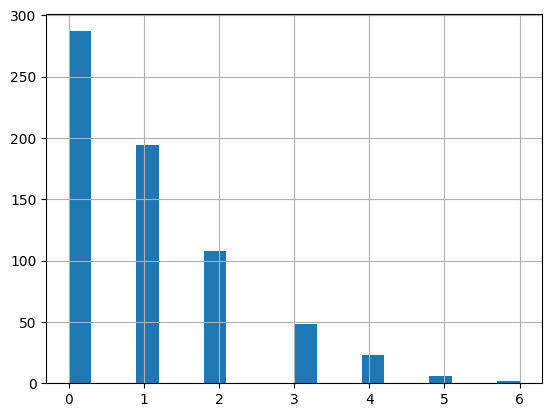

In [ ]:
overlap= []
num_rec = []
n = 20
for user in ratings.userId.unique():
    top_items = model.topN(user=user, n=n)
    user_movies = ratings.loc[(ratings.userId==user)].movieId
    valid_rec = set(top_items).intersection(set(user_movies)) # I can only measure by what was in the training data

    _ = len(set(ratings.loc[ratings.userId==user].sort_values(by='rating', ascending=False).head(n).movieId).intersection(set(valid_rec)))
    overlap.append(_)
    num_rec.append(len(valid_rec))

print('avg_perc_overlap:', np.array(overlap).mean() / np.array(num_rec).mean())
pd.Series(overlap).hist(bins=20)

Now Let's understand about another metric called **K-precision**

### What is K-precision?

- K-Precision is a metric used to evaluate the quality of recommendations provided by recommendation systems.
- It assesses how many of the top-K recommended items are relevant to the user's preferences.
- A higher K-Precision value indicates better recommendation quality.

<center><img src="https://drive.google.com/uc?id=1DO8xfPMTT61g1lgFVpYd0DRqeQZuue-I"></center>


If I made K predictions, how many of those K were relevant?

avg: 0.7849889642782759


<Axes: >

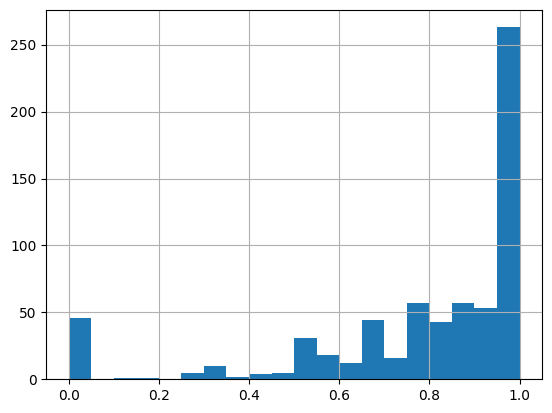

In [ ]:
overlap=[]
for user in ratings.userId.unique():
    recommendations = model.topN(user=user, n=100)
    user_movies = ratings.loc[(ratings.userId==user)].movieId
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.userId==user) & (ratings.rating>=4)].movieId
    try:
        _ = len(set(recommendations).intersection(set(relevant_items))) / len(valid_rec)
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins=20)

if I make, K predictions, how many relevant items was able to find?

avg: 0.21475637378786894


<Axes: >

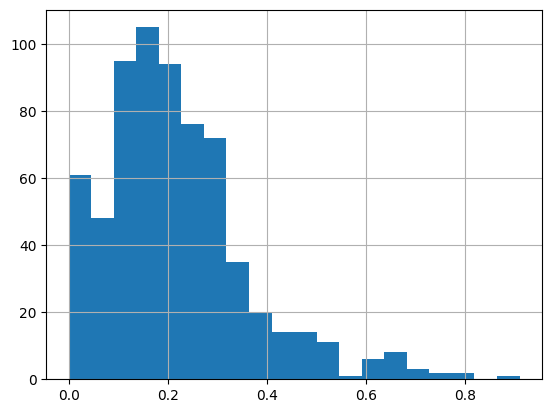

In [ ]:
overlap=[]
for user in ratings.userId.unique():
    recommendations = model.topN(user=user, n=100)
    user_movies = ratings.loc[(ratings.userId==user)].movieId
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.userId==user) & (ratings.rating>=4)].movieId
    try:
        _ = len(set(recommendations).intersection(set(relevant_items))) / len(set(relevant_items))
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins=20)